# Data Loading and Inspection

This notebook demonstrates how to load and inspect microscopy time-lapse data for the E. coli Tracking project.

In [1]:
import os
import sys
import numpy as np
import matplotlib.pyplot as plt
from pathlib import Path
import tifffile

# Add the project root to the path so we can import our modules
project_root = Path(os.getcwd()).parent.parent
sys.path.append(str(project_root))

from src.data.loader import DataLoader

In [2]:
# ## Configure Data Paths

# Define data paths
data_dir = Path(project_root) / 'data'
timelapse_data_dir = data_dir / 'timelapse_data' / 'LB_data'

# Display available data directories
print(f"Available data directories:")
for d in data_dir.iterdir():
    if d.is_dir():
        print(f"- {d.name}")

# Check if data directory exists and has expected structure
if not data_dir.exists():
    print("❌ Data directory not found!")
    print("Run 'python setup_data.py' to create the data structure")
else:
    print("✅ Data directory found")

Available data directories:
- training_data
- timelapse_data
- models
- examples
- elongated_morphology
- processed
✅ Data directory found


In [3]:
# ## Load and Inspect Test Data

# Initialize the data loader
loader = DataLoader(timelapse_data_dir)

# List available files
print("Available files in test data directory:")
for f in timelapse_data_dir.iterdir():
    if f.is_file():
        print(f"- {f.name} ({f.stat().st_size / 1e6:.1f} MB)")

# Load the original images
try:
    original_images = loader.load_image_stack('original_images.tif')
    print(f"Original images loaded: {original_images.shape}, dtype: {original_images.dtype}")
except FileNotFoundError as e:
    print(f"Error: {e}")

# Load the segmentation masks
try:
    masks = loader.load_masks('masks.tif')
    print(f"Masks loaded: {masks.shape}, dtype: {masks.dtype}")
except FileNotFoundError as e:
    print(f"Error: {e}")

# Load the ground truth
try:
    ground_truth = loader.load_masks('ground_truth.tif')
    print(f"Ground truth loaded: {ground_truth.shape}, dtype: {ground_truth.dtype}")
except FileNotFoundError as e:
    print(f"Error: {e}")


Available files in test data directory:
- .DS_Store (0.0 MB)
- original_images.tif (1077.3 MB)
- ground_truth.tif (6.0 MB)
- masks.tif (269.4 MB)
- LB_ROI1_JVH.csv (372.9 MB)
Original images loaded: (361, 841, 887), dtype: float32
Masks loaded: (361, 841, 887), dtype: uint8
Ground truth loaded: (361, 841, 887), dtype: uint32


In [4]:
# ## Visualize Sample Data

def plot_frame(images, masks=None, frame_idx=0):
    """Plot a frame with optional masks overlay"""
    plt.figure(figsize=(12, 8))
    
    if masks is not None:
        # Plot image with mask overlay
        plt.subplot(1, 2, 1)
        plt.imshow(images[frame_idx], cmap='gray')
        plt.title(f"Original Image (Frame {frame_idx})")
        plt.axis('off')
        
        plt.subplot(1, 2, 2)
        plt.imshow(images[frame_idx], cmap='gray')
        
        # Create mask overlay
        mask_frame = masks[frame_idx]
        if mask_frame.dtype == bool:
            plt.imshow(mask_frame, alpha=0.3, cmap='jet')
        else:
            # For label masks
            from skimage.color import label2rgb
            overlay = label2rgb(mask_frame, bg_label=0, alpha=0.3)
            plt.imshow(overlay, alpha=0.3)
        
        plt.title(f"Mask Overlay (Frame {frame_idx})")
        plt.axis('off')
    else:
        # Just plot the image
        plt.imshow(images[frame_idx], cmap='gray')
        plt.title(f"Frame {frame_idx}")
        plt.axis('off')
        
    plt.tight_layout()
    plt.show()

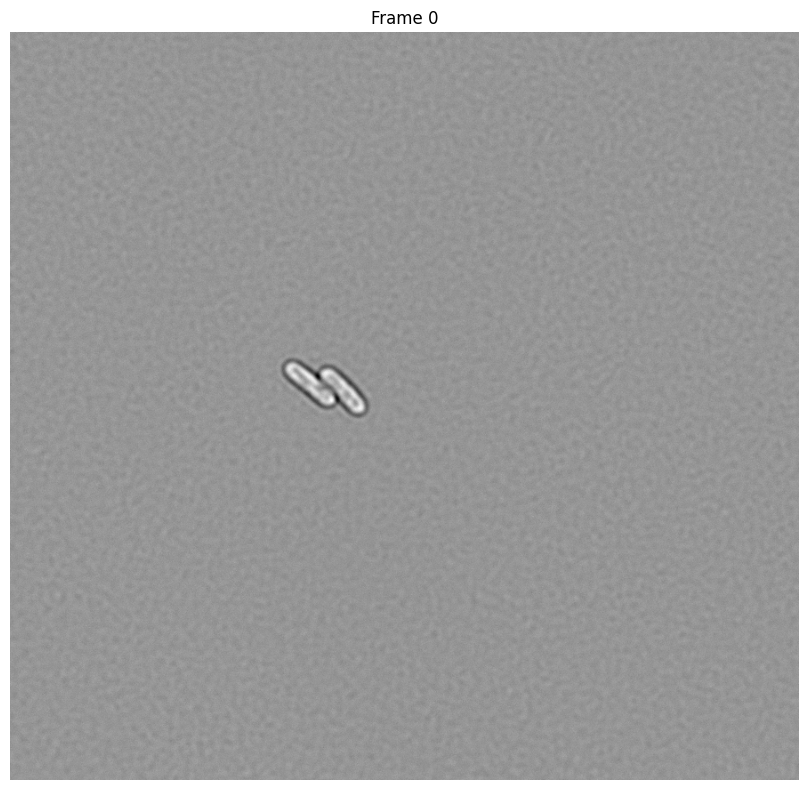

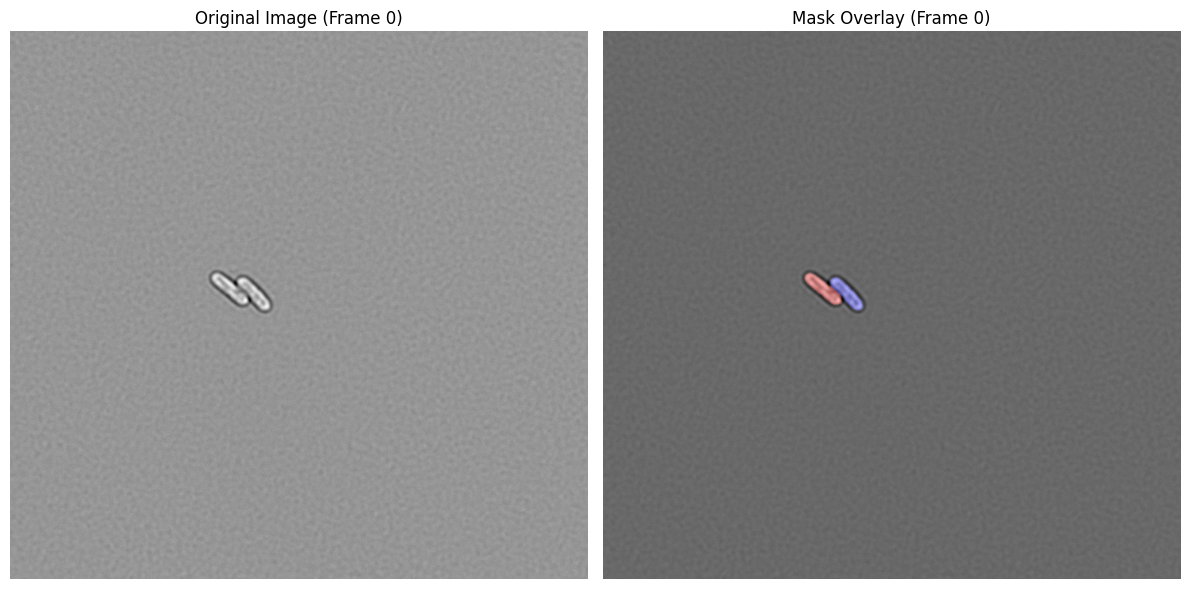

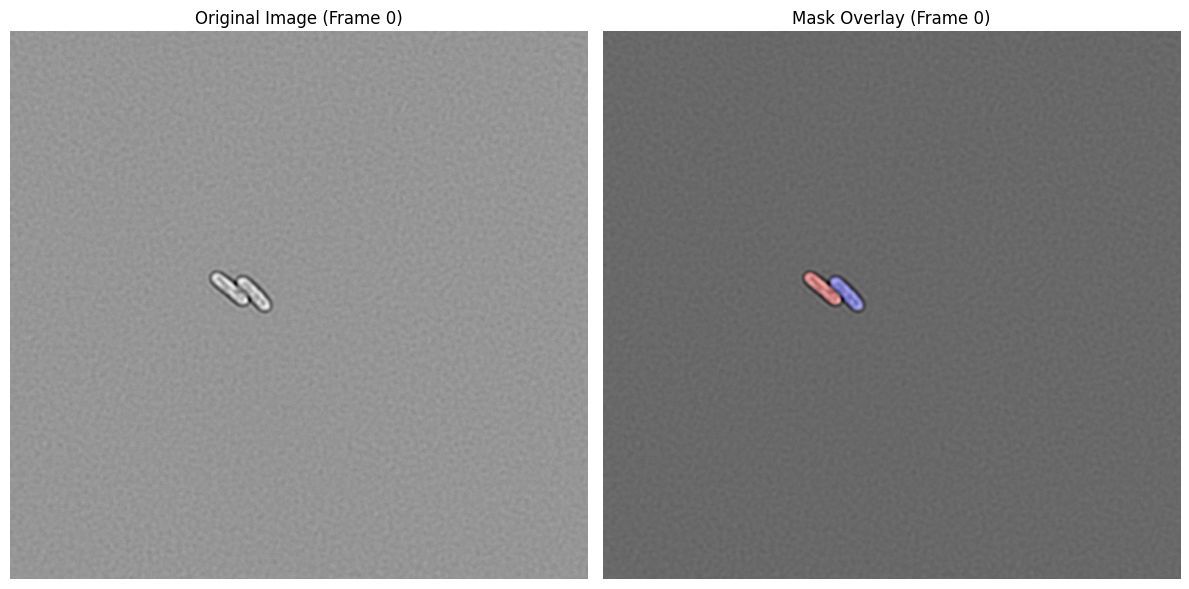

In [5]:
# Visualize a sample frame
frame_idx = 0  # Show the first frame

try:
    # Plot just the image
    plot_frame(original_images, frame_idx=frame_idx)
    
    # Plot with mask overlay
    plot_frame(original_images, masks, frame_idx=frame_idx)
    
    # Plot with ground truth overlay
    plot_frame(original_images, ground_truth, frame_idx=frame_idx)
except NameError as e:
    print(f"Error: {e} - Make sure the data is loaded properly.")

In [6]:
# ## Data Statistics

# Calculate basic statistics for the datasets
def print_statistics(name, data):
    """Print basic statistics for the dataset"""
    print(f"{name} statistics:")
    print(f"  Shape: {data.shape}")
    print(f"  Dtype: {data.dtype}")
    print(f"  Min value: {data.min()}")
    print(f"  Max value: {data.max()}")
    
    if data.dtype != bool and name != "Original Images":
        # For label masks, count objects per frame
        objects_per_frame = [len(np.unique(frame)) - 1 for frame in data]  # -1 to exclude background
        print(f"  Average objects per frame: {np.mean(objects_per_frame):.1f}")
        print(f"  Min objects: {min(objects_per_frame)}")
        print(f"  Max objects: {max(objects_per_frame)}")
    
    print("")

try:
    print_statistics("Original Images", original_images)
    print_statistics("Masks", masks)
    print_statistics("Ground Truth", ground_truth)
except NameError as e:
    print(f"Error: {e} - Make sure the data is loaded properly.")

# ## Save Processed Data (if needed)

# Example of saving processed data
# processed_dir = data_dir / 'processed' / 'timelapse_data'
# processed_dir.mkdir(exist_ok=True, parents=True)
# 
# # Example: Save a subset of frames
# subset_frames = original_images[:10]  # First 10 frames
# tifffile.imwrite(processed_dir / 'subset_frames.tif', subset_frames)

# ## Conclusion
#
# In this notebook, we have:
# 1. Loaded the original images, segmentation masks, and ground truth data
# 2. Visualized sample frames with and without mask overlays
# 3. Calculated basic statistics for the datasets

Original Images statistics:
  Shape: (361, 841, 887)
  Dtype: float32
  Min value: -25999.0
  Max value: 18845.0

Masks statistics:
  Shape: (361, 841, 887)
  Dtype: uint8
  Min value: 0
  Max value: 255
  Average objects per frame: 66.2
  Min objects: 2
  Max objects: 255

Ground Truth statistics:
  Shape: (361, 841, 887)
  Dtype: uint32
  Min value: 0
  Max value: 2392
  Average objects per frame: 65.3
  Min objects: 2
  Max objects: 254

